# 1. Perkenalan

Nama  : Fahmi

Batch : RMT-34

## 1.1. Gambaran Besar Dataset

Dataset ini mencakup ribuan foto orang-orang yang merokok (smoking) dan tidak merokok (not_smoking) yang diambil dari Kaggle dengan berbagai rentang usia, kelamin, maupun sudut pengambilan gambar.

## 1.2. Objective

Notebook ini berisi pembuatan model deteksi tindakan, apakah seseorang merokok atau tidak. Model ini menggunakan teknik deep learning, tepatnya CNN. Model ini bisa dipakai untuk melacak pengunjung di suatu tempat merokok atau tidak.

Dengan begitu, model ini bisa dimanfaatkan misalnya di suatu ruang publik yang dilarang merokok, apakah pengunjungnya melanggar atau tidak.

# 2. Import Libraries

Pertama-tama, mari upgrade dahulu scipy ke versi terbaru. Barulah kemudian, import modul maupun pustaka yang sekiranya digunakan dalam project kali ini.

In [1]:
# upgrade scipy
!pip install --upgrade scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 8.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


In [2]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import  layers , models ,optimizers
from tensorflow import  keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.utils import shuffle
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
import imgaug.augmenters as iaa
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from google.colab import drive
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV3Large


#3. Data Loading

Setelah itu, mari load dataset yang dibutuhkan. Ada 2 tahapan pada proses ini.

Pertama ialah mengunduh data. Nantinya data diunduh dalam chunk yang telah ditentukan ukurannya kira-kira sebesar 40KB. Lalu, diekstraksi dari file yang dikompresi. Berikut selengkapnya.

In [3]:
# menentukan ukuran chunck saat mengunduh jadi 40KB-an
CHUNK_SIZE = 40960

# memvariabelkan URL ter-encode dari data yang mau diunduh
DATA_SOURCE_MAPPING = 'smoking:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4012063%2F6981583%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240905%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240905T105802Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D47661f8fb5530fcc863bbed42aeb0ee74b8570a031c294cb2833bf2eea14dd3c332e198895628f2149263896a65c41d8ce33c139943fadf78c898858aa75bfb3e8bbbc85bab4d8badc0f60a10a6f5683ad1f9566fdd1c6c12562ae83fc20035d1c8d2d605cc79651887ee638baf538f11c7afe9231ae2ddb688c9e2b58bf32feca3883e938cf968f81c43bcdaf574c90b50cf7bbec89e9afc8e4050d7d13d045f930e9194555313a661d922ba2531c17c0119c47a1d3f41bf9db93244a477269f4e60afaf1c3053d5354b6bde7bbc9550a9c603576b8a38e74ea9f43a352ca0f592b2909a209261e19af6037eb2f434638cbc4f371d0842b8656e0fb3f5912d8'

# mengatur direktori input, working, dan symlink
KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

# unmount & pembutan direktori
!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

# pembuatan symlink
try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
      # pengunduhan
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    # error handling
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

# indikator output
print('Data source import complete.')


[==================================================] 66851896 bytes downloaded
Downloaded and uncompressed: smoking
Data source import complete.


Langkah kedua ialah, load dan pengelompokan gambar. Gambar tersebut diambil dan diubah ukurannya, kemudian diklasifikasikan ke dalam 2 kategori, yakni smoking dan not_smoking. Barulah, gambar-gambar itu disimpan sesuai kategori.

In [4]:
# Direktori dataset
dataset_path = '/kaggle/input/smoking/Training/Training'
img_size = 250

# Inisialisasi variabel
smoking = []
not_smoking = []

# Iterasi melalui dataset
for img_name in os.listdir(dataset_path):
    img_path = os.path.join(dataset_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))

    if img_name[:3] == 'not':  # Deteksi kategori not_smoking
        not_smoking.append(img)
    else:  # Kategori smoking
        smoking.append(img)

Tahapan untuk load data berhasil.

# 3. EDA

Pada tahapan ini, saya akan melakukan sejumlah analisis terhadap dataset yang saya miliki

## 3.1. Distribusi Label

Analisis yang paling pertama saya lakukan ialah memastikan kategori yang saya telusuri, yakni smoking dan not_smoking, seimbang atau tidak. Dari sana, saya bisa memastikan apakah perlu tindakan tambahan, seperti oversampling atau data augmentation, guna mencegah bias.

<ipython-input-5-6eaf789f8d2b>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=counts, palette="coolwarm")


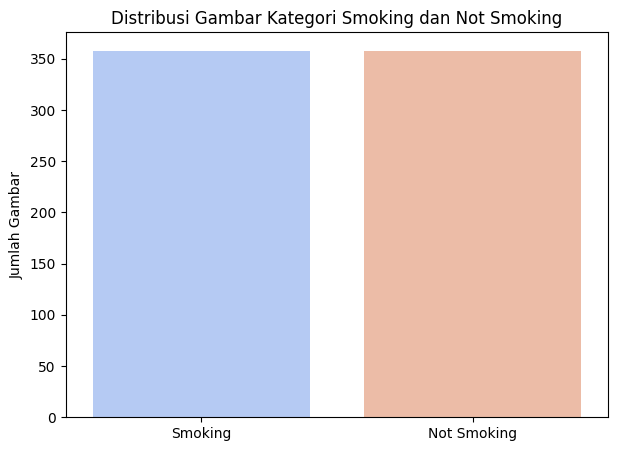

In [5]:
categories = ['Smoking', 'Not Smoking']
counts = [len(smoking), len(not_smoking)]

plt.figure(figsize=(7, 5))
sns.barplot(x=categories, y=counts, palette="coolwarm")
plt.title('Distribusi Gambar Kategori Smoking dan Not Smoking')
plt.ylabel('Jumlah Gambar');

Walhasil, kedua kategori saya memiliki jumlah yang sama. Jadi, distribusinya seimbang (balanced). Dengan begitu, saya sebetulnya tidak perlu melakukan tindakan tambahan.

## 3.2. Distribusi Ukuran Gambar

Analisis kedua, yaitu mengecek ukuran gambar. Saya ingin memastikan konsistensi ukuran gambar sebelum digunakan lebih lanjut. Jika ada yang tidak seragam (tinggi dan lebarnya), langkah preprocessing tambahan seperti resizing akan dibutuhkan nantinya.

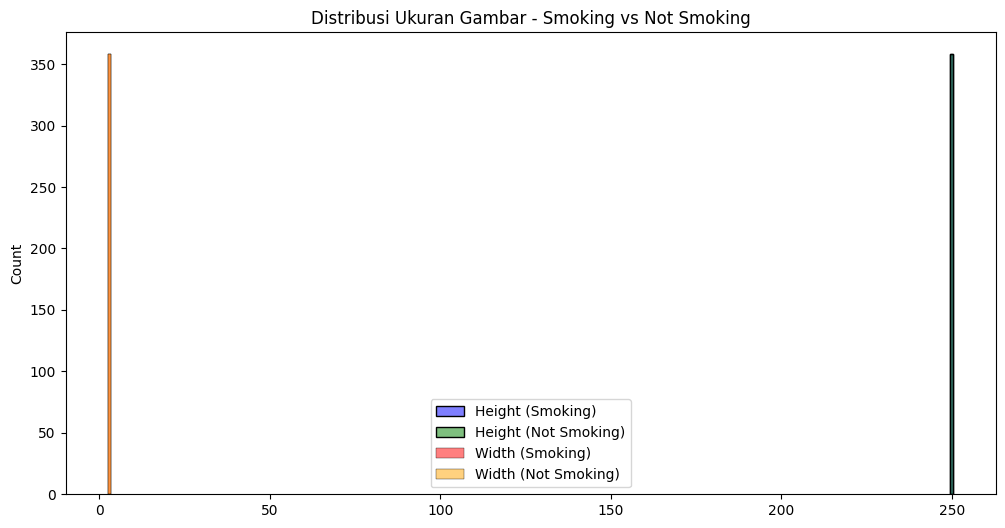

In [6]:
# Initialize image_shapes for both categories as empty lists
smoking_image_shapes = []
not_smoking_image_shapes = []

# Extract shapes for smoking images
smoking_image_shapes += [img[0].shape for img in smoking]
smoking_image_heights = [shape[0] for shape in smoking_image_shapes]
smoking_image_widths = [shape[1] for shape in smoking_image_shapes]

# Extract shapes for not smoking images
not_smoking_image_shapes += [img[0].shape for img in not_smoking]
not_smoking_image_heights = [shape[0] for shape in not_smoking_image_shapes]
not_smoking_image_widths = [shape[1] for shape in not_smoking_image_shapes]

# Plot the distributions
plt.figure(figsize=(12, 6))

# Plot height distribution for smoking and not smoking
sns.histplot(smoking_image_heights, color='blue', label='Height (Smoking)', kde=True)
sns.histplot(not_smoking_image_heights, color='green', label='Height (Not Smoking)', kde=True)

# Plot width distribution for smoking and not smoking
sns.histplot(smoking_image_widths, color='red', label='Width (Smoking)', kde=True)
sns.histplot(not_smoking_image_widths, color='orange', label='Width (Not Smoking)', kde=True)

# Display plot settings
plt.legend()
plt.title('Distribusi Ukuran Gambar - Smoking vs Not Smoking')
plt.show()


Menurut grafik di atas, semua gambar rupanya memiliki ukuran yang seragam, yaitu sekitar 250 x 250 piksel, baik untuk kategori smoking maupun not_smoking.
Hal tersebut terlihat dari grafik yang menunjukkan satu garis lurus pada nilai tertentu untuk tinggi dan lebar gambar.

## 3.3. Visualisasi Contoh Gambar Berdasarkan Label

Analisis berikutnya, menampilkan sampel gambar dari kategori "Smoking" dan "Not Smoking".

Langkah ini sebagai validasi apakah gambar telah dimuat (di-load) dengan benar, memastikan kategori gambar tak tercampur, dan memberi gambaran visual tentang pola dalam gambar yang mungkin berkontribusi pada perbedaan antarkategori.

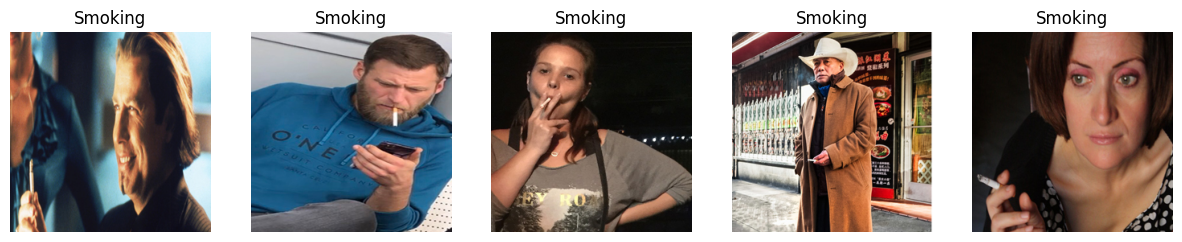

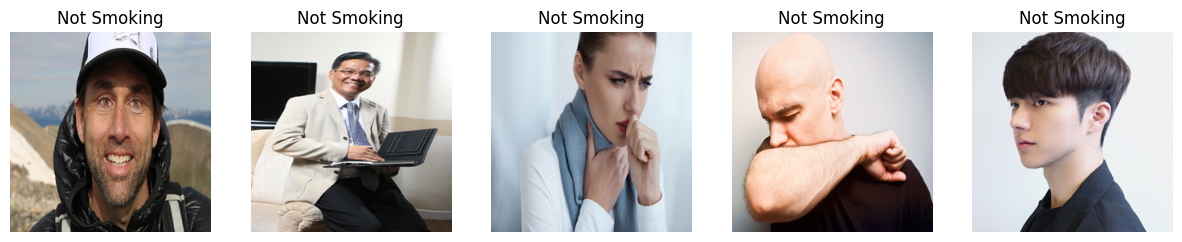

In [7]:
# Visualisasi beberapa gambar dari kelas 'smoking' dan 'not_smoking'
def display_sample_images(images, label, num_images=5):
    plt.figure(figsize=(15,5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title(label)
        plt.axis('off')
    plt.show()

# Tampilkan beberapa gambar dari kategori 'smoking' dan 'not_smoking'
display_sample_images(smoking, 'Smoking')
display_sample_images(not_smoking, 'Not Smoking')

Diketahui:

- Tidak ada yang salah dalam pelabelan pada gambar-gambar tersebut, baik Smoking maupun Not Smoking

-  Ada beberapa pola visual yang dapat berkontribusi pada perbedaan antara kategori "Smoking" dan "Not Smoking".


  1. Keberadaan rokok/asap:<br><br>
  Kategori "Smoking": Hampir semua gambar menampilkan rokok atau asap yang tampak jelas. <br><br>
  Kategori "Not Smoking": Tidak ada rokok atau asap yang terlihat.


  2. Posisi tangan:<br><br>
  Kategori "Smoking": Beberapa gambar menunjukkan tangan di dekat mulut, memegang rokok. <br><br>
  Kategori "Not Smoking": Posisi tangan bervariasi, tidak ada yang memegang rokok.


  3. Ekspresi wajah:<br><br>
  Kategori "Smoking": Ekspresi cenderung lebih santai atau intens.<br><br>
  Kategori "Not Smoking": Ekspresi lebih beragam, termasuk kekhawatiran atau konsentrasi.


  4. Konteks:<br><br>
  Kategori "Smoking": Beberapa gambar menunjukkan setting luar ruangan atau situasi sosial.<br><br>
  Kategori "Not Smoking": Konteks lebih beragam, termasuk situasi kerja dan medis.


  5. Fokus gambar:<br><br>
  Kategori "Smoking": Fokus sering pada wajah dan tangan.<br><br>
  Kategori "Not Smoking": Fokus lebih bervariasi, termasuk close-up wajah dan gambar yang lebih luas.



Untuk memastikan performa model cukup bagus, saya memutuskan untuk melakukan data augmentation pada tahapan feature engineering nanti.

# 5. Feature Engineering

## 5.1 Split Train & Test Data

- Pada bagian ini, saya akan memisahkan mana yang termasuk X-train, X-test, y-train, dan y-test.

- Namun, di sini, saya akan melakukannya secara manual dengan Numpy. Maka itu, ada sejumlah tahapan sebagai berikut.

### 5.1.1. Split Train & Test-Set

Langkah pertama dalam split train & test data di sini ialah dengan membaginya dahulu menjadi train dan test-setnya. Adapun skripnya berikut ini.

In [8]:
# mengelompokkan gambar-gambar untuk train data
dataset_path = '/kaggle/input/smoking/Training/Training'
img_size = 250

train_data = []
train_labels = []
train_paths = []
# Iterasi melalui direktori dataset
for img_name in os.listdir(dataset_path):

    if(img_name[:3] == 'not'):
      img_class = 'notsmoking'
    else :
      img_class = 'smoking'
    train_labels.append(img_class)
    img_path = os.path.join(dataset_path, img_name)
    train_paths.append(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    train_data.append([img,img_class])

Sampai sini, seharusnya saya sudah berhasil mengelompokkan gambar-gambar yang termasuk train data. Namun, saya akan memastikannya kembali dengan menampilkan label dan visual dari gambar pertama dari train data.

In [9]:
# cek label dari gambar pertama
train_data[0][1]

'smoking'

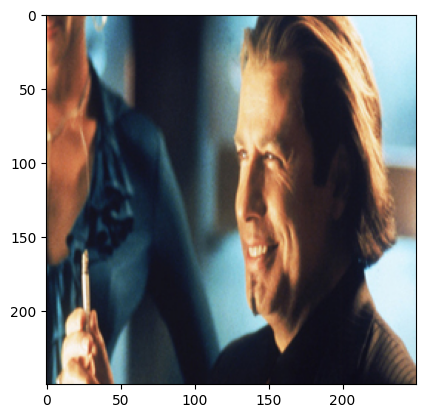

In [10]:
# menampilkan gambar pertama
plt.imshow(train_data[0][0])

Di sini, saya rasa pengelompokkan untuk train data saya sudah berhasil. Tidak ada miss dalam pelabelannya. Akan tetapi, mari sekali lagi memastikannya dengan menampilkan path dari 3 gambar pertama dan mencocokkannya dengan label masing-masing.

In [11]:
# menampilkan path yang berisi gambar
train_paths[:3]

['/kaggle/input/smoking/Training/Training/smoking_0359.jpg',
 '/kaggle/input/smoking/Training/Training/notsmoking_0050.jpg',
 '/kaggle/input/smoking/Training/Training/smoking_0492.jpg']

In [12]:
# menampilkan labelnya
train_labels[:3]

['smoking', 'notsmoking', 'smoking']

Saya rasa tidak ada masalah dengan train-set. Mari lanjut ke test-set.

In [13]:
# mengelompokkan gambar-gambar untuk test data
dataset_path = '/kaggle/input/smoking/Testing/Testing'

test_data = []
test_labels = []
test_paths = []
# # Iterasi melalui direktori dataset
for img_name in os.listdir(dataset_path):
    if(img_name[:3] == 'not'):
      img_class = 'notsmoking'
    else :
      img_class = 'smoking'
    test_labels.append(img_class)
    img_path = os.path.join(dataset_path, img_name)
    test_paths.append(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_data.append([img,img_class])

Seperti saat di train set, saya juga akan melakukan sejumlah tes untuk memastikan tidak ada masalah dalam pengelompokkan train-set.

In [14]:
# menampilkan label gambar pertama test-set
test_data[0][1]

'notsmoking'

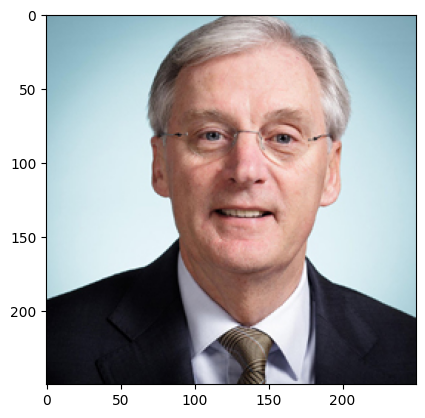

In [15]:
# menampilkan gambar pertama test-set
plt.imshow(test_data[0][0])

In [16]:
# menampilkan path 3 gambar pertamanya
test_paths[:3]

['/kaggle/input/smoking/Testing/Testing/notsmoking_0049.jpg',
 '/kaggle/input/smoking/Testing/Testing/notsmoking_0026.jpg',
 '/kaggle/input/smoking/Testing/Testing/smoking_0474.jpg']

In [17]:
# menampilkan label 3 gambar pertama test-set
test_labels[:3]

['notsmoking', 'notsmoking', 'smoking']

Dari sini, saya meyakini tidak ada masalah pula dari pengelompokkan test-set. Mari beranjak ke tahapan selanjutnya.

### 5.1.2. Shuffle Data

Setelah mengelompokkan gambar untu train-set dan test-set, saya lalu mengacaknya guna menghindari bias dan overfit.

In [18]:
# mengacak urutan data guna menghindari bias
random.shuffle(train_data)
random.shuffle(test_data)

Seharusnya, proses shuffle sudah berhasil. Mari dicek lebih dahulu dengan menampilkan label pada 3 gambar pertama train-set.

In [19]:
# iterasi untuk menampilkan label gambar
for item in train_data[:3]:
  print(item[1])

notsmoking
notsmoking
smoking


Tidak ada masalah. Dengan begini, proses mengacak urutan gambar train-set dan test-set dirasa tidak ada masalah.

### 5.1.3 Splitting

Walakhir, saya akan mebaginya ke dalam X-train, X-test, y-train, y-test.

In [20]:
# inisialisasi list kosong
x_train , x_test , y_train , y_test = [] , [] , [] , []

# fungsi memisahkan fitur dan label
def extract_splits(data):
    for features ,label  in data  :

        if(data == train_data):
            x_train.append(features)
            y_train.append(label)
        else:
            x_test.append(features)
            y_test.append(label)

In [21]:
# memisahkan fitur dan label train data
extract_splits(train_data)

In [22]:
# memisahkan fitur dan label test data
extract_splits(test_data)

### 5.1.4 Turn Data into Numpy Array

Agar mudah digunakan untuk pembuatan model, data yang telah di-split tadi mesti dubah ke NumPy array.

In [23]:
# ubah list ke array
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

Setelah itu, mari cek jumlah hasil split

In [24]:
# cek hasil split
print("x_train shape ",x_train.shape)
print("y_train shape ",y_train.shape)

print("x_train shape ",x_test.shape)
print("y_train shape ",y_test.shape)

x_train shape  (716, 250, 250, 3)
y_train shape  (716,)
x_train shape  (224, 250, 250, 3)
y_train shape  (224,)


Tampaknya tidak ada masalah setelah proses splitting. Namun, mari cek sekali lagi

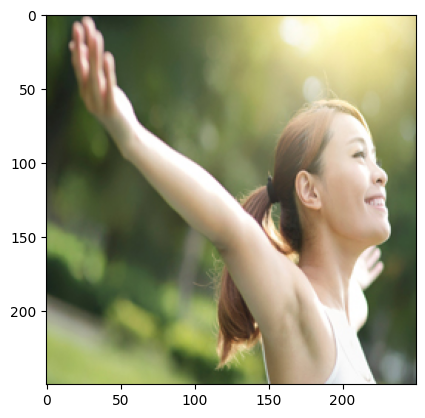

In [25]:
# menampilkan gambar indeks ke-3 dari dataset X_train
plt.imshow(x_train[3])

In [26]:
# menampilkan label gambar indeks ke-3 dari y-train
y_train[3]

'notsmoking'

Tidak ada masalah maka proses split train dan test data saya yakini telah berhasil.

##5.2. Encoding Label

Pada tahapan ini, saya akan melakukan encoding pada label, baik terhadap y-train dan y-test.

In [27]:
# meng-encode label
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

Setelah itu, mari dicek apakah proses encoding berhasil.

In [28]:
y_train_encoded[0]

0

Itu berhasil dari yang semula 'smoking' atau 'notsmoking', kini berubah menjadi 0 atau 1 mengingat ini binary classification.

## 5.3. Data Augmantaion

Meskipun secara distribusi jumlah dataset `smoking` dan `notsmoking` sebenarnya sama dan seimbang. Saya masih akan melakuakn data augmentation (augmentasi data).

Itu dilakukan agar model belajar lebih baik dengan melihat variasi data yang lebih luas, seperti perubahan sudut, rotasi, dan lainnya. Langkah itu juga mencegah overfitting.

Pada langkah ini, saya terlebih dahulu membuat 2 fungsi. Fungsi pertama ialah `display_seq_images` untuk memeriksa hasil augmentasi dan memastikan bahwa transformasi yang diterapkan sesuai dengan yang diharapkan.

In [29]:
# buat fungsi untuk menampilkan hasil augmentasi
def display_seq_images(images, labels, num_images=5):
    num_total_images = len(images)

    fig, axes = plt.subplots(1, num_images, figsize=(30, 5))
    for i, idx in enumerate(range(num_images)):
        axes[i].imshow(images[idx], aspect='auto')

        axes[i].set_title(labels[idx])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

Fungsi kedua, barulah untuk proses augmentasi dengan memperbanyak jumlah data pelatihan. Di akhir skrip, saya akan langsung menerapkan fungsi ini ke train data.

In [30]:
# fungsi untuk augmentasi data
def augment_images(images, labels, num_augmentations=4):
    augmented_images = []
    augmented_labels = []

    # Define augmentation sequence
    seq = iaa.Sequential([
        iaa.Fliplr(1.0),  # Horizontal flip with 100% probability
        iaa.Multiply((1.5, 2.5), per_channel=0.5)  # Adjust saturation
    ])

    # Apply augmentation to each image
    for original_image, label in zip(images, labels):
        augmented_images.append(original_image)  # Add original image
        augmented_labels.append(label)

        # Apply augmentation to create additional augmented images
        augmented_images.extend(seq(images=[original_image] * (num_augmentations)))
        augmented_labels.extend([label] * (num_augmentations))

    return np.array(augmented_images), np.array(augmented_labels)

num_augmentations = 4

# Apply augmentation to the entire training dataset
augmented_images,augmented_labels = augment_images(x_train,y_train_encoded ,num_augmentations)

Sebenarnya sampai sini, proses augmentasi data sudah selesai. Akan tetapi, saya akan mengecek hasilnya terlebih dahulu dengan menampilkan sampel menggunakan fungsi pertama.

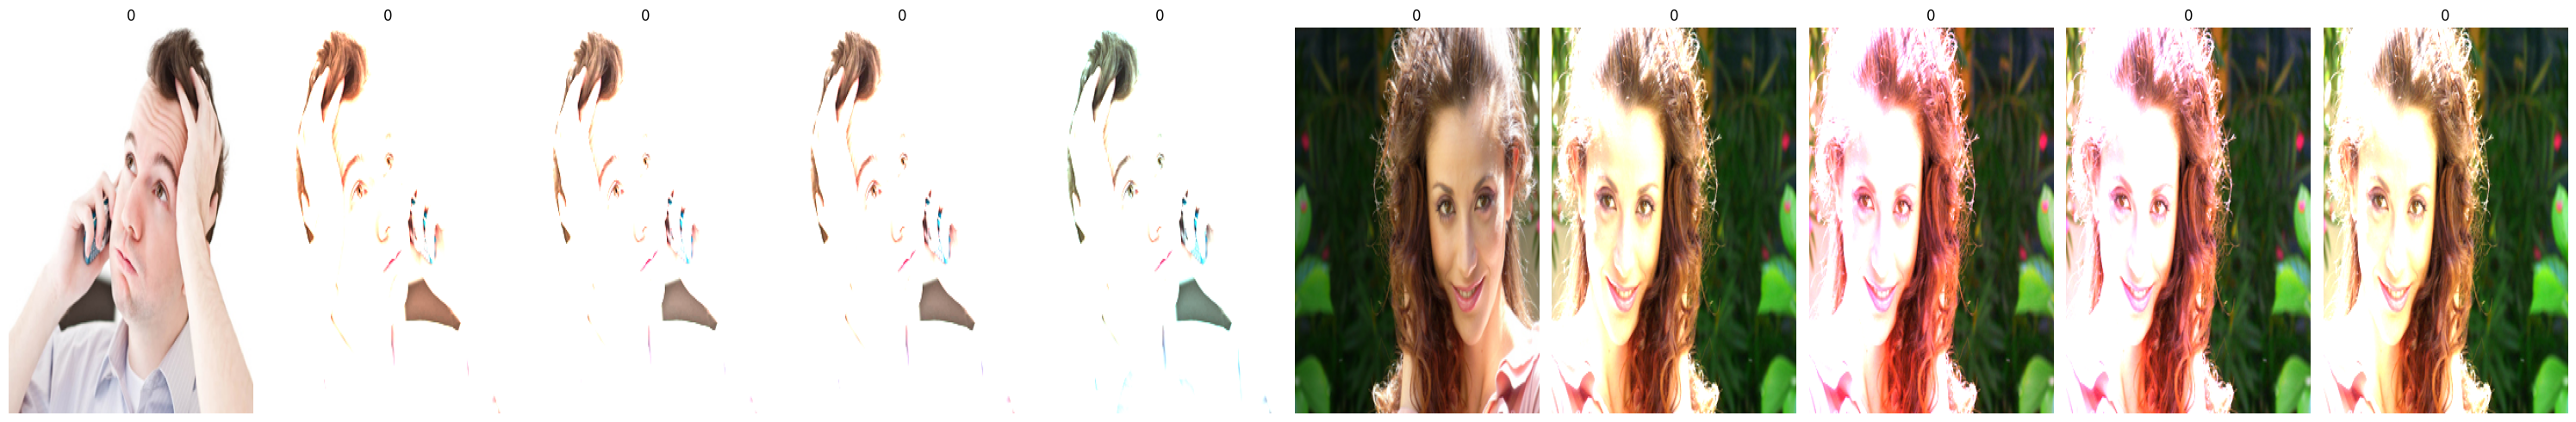

In [31]:
# menampilkan 10 gambar dari array augmented_images bersama dengan labelnya.
display_seq_images(augmented_images,augmented_labels,10)

Proses augmentasi tampaknya berhasil. Ada 2 gambar yang telah diperbanyak variasinya berdasarkan posisi maupun kecerahan gambarnya. Selain itu, labelnya (pada atas gambar) juga konsisten.

# 6. ANN Training

Pada tahapan ini, saya akan melakukan training dengan model yang saya bangun infrastrukturnya sendiri.

## 6.1. Model Definition

Sebelum membangun model, saya akan memastikan dahulu bahwa hasil model training akan konsisten. Caranya dengan mengatur seed dahulu sebagai berikut.

In [32]:
# Mengatur seed
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

Setelah mengatur seed, saya akan membuat infrastruktur model sequential CNN yang terdiri dari input layer, sejumlah hidden layer, dan output layer. Selain itu, juga terdapat layer droput, flatten, dan maxpooling.

In [33]:
# Arsitektur model CNN
model = models.Sequential([
    # Layer Convolutional 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2, 2)),

    # Layer Convolutional 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Layer Convolutional 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Layer Convolutional 4
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten untuk mempersiapkan data masuk ke fully connected layer
    layers.Flatten(),

    # Fully Connected Layer 1
    layers.Dense(512, activation='relu'),

    # Dropout untuk regularisasi (mencegah overfitting)
    layers.Dropout(0.5),

    # Output Layer (karena klasifikasi 2 kelas, gunakan 1 unit dengan sigmoid)
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), # menentukan bagaimana model belajar
              loss='binary_crossentropy', # apa yang akan dioptimalkan
              metrics=['accuracy']) # apa metriksnya

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Setelah dibangun arsitektur model dan ditentukan model compile-nya, saya akan melihat ringkasannya sebagai berikut.

In [34]:
# Summary model untuk melihat arsitektur
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 248, 248, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 59, 59, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 27, 27, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      11,076,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,317,441 (43.17 MB)

 Trainable params: 11,317,441 (43.17 MB)

 Non-trainable params: 0 (0.00 B)

Ada sejumlah poin dari ringkasan yang ditampilkan di atas:

**Arsitektur Model:**

- Model ini memakai arsitektur sequential dengan total 12 layer.
- Itu terdiri dari 4 blok convolutional (Conv2D) yang diikuti oleh max pooling (MaxPooling2D).
- Diakhiri dengan flattening, dense layer, dropout, dan output layer.


**Layer Convolutional:**

- Ada 4 layer Conv2D (conv2d_12 hingga conv2d_15).
- Jumlah filter meningkat dari 32, 64, 128, hingga 128.
- Ukuran output berkurang seiring bertambahnya kedalaman layer (dari 248x248 menjadi 27x27).


**Max Pooling:**

- Setiap layer Conv2D diikuti oleh MaxPooling2D untuk down-sampling.
Itu membantu mengurangi dimensi spasial dan jumlah parameter.


**Flattening dan Dense Layers:**

- Setelah convolutional blocks, output di-flatten menjadi vektor 1D (21.632 unit).
- Terdapat dua dense layer: dense_6 (512 unit) dan dense_7 (3 unit sebagai output layer).


**Dropout:**

Ada satu layer dropout (dropout_3) dengan 512 unit. Itu untuk mengurangi overfitting.


**Jumlah Parameter:**

Total parameter: 11,317,441 (sekitar 43.17 MB).
Semua parameter dapat dilatih (trainable).
Tidak ada parameter yang non-trainable.

Untuk lebih jelasnya, saya tampilkan ringkasan dalam versi visualnya sebagai berikut.

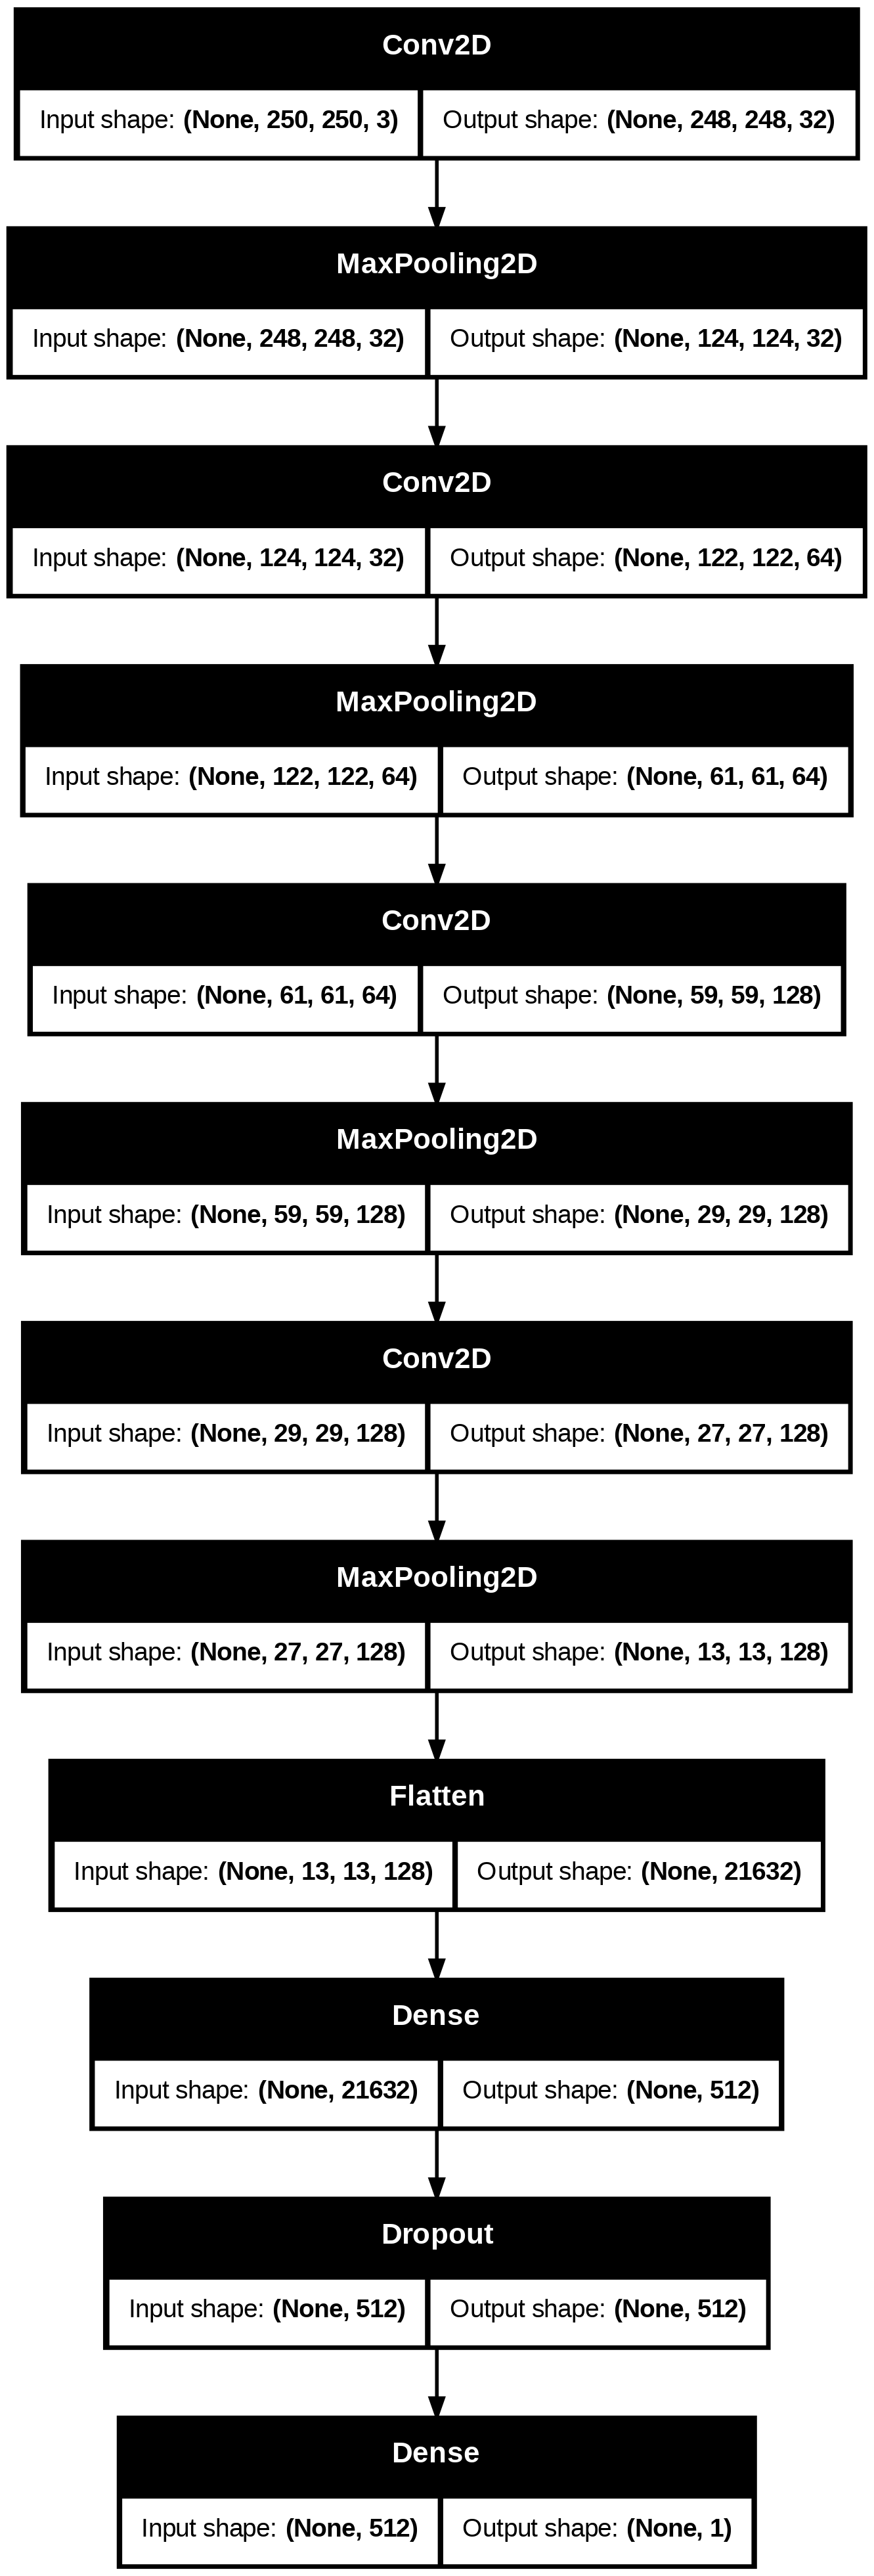

In [35]:
# menampilkan arstitektur model secara visual
tf.keras.utils.plot_model(model , show_shapes = True)

##6.2. Model Training

Sebelum melakukan model training, saya akan memastikan tipe data dari label. Itu karena untuk tugas klasifikasi, model membutuhkan label bertipe integer, bukan float, apalagi string.

In [36]:
# cek tipe data label
augmented_labels[0].dtype

dtype('int64')

Ternyata labelnya sudah bertipe integer. Jadi, saya tidak perlu mengubahnya terlebih dahulu.

Kemudian saya menentukan 2 paramter, yakni `epoch` (jumlah berapa kali model akan dilatih melalui dataset) dan `batch_size` (jumlah berapa sampel gambar yang diproses sekali jalan agar tidak terlalu berat)

In [37]:
# menentukan epoch
epochs=30

# menentukan batch size
batch_size = 8

Barulah saya melatih model sebagai berikut.

In [38]:
# Train the model with batches
history = model.fit(augmented_images, augmented_labels, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test_encoded))

Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.6681 - loss: 2.2214 - val_accuracy: 0.6920 - val_loss: 0.5922
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8623 - loss: 0.3079 - val_accuracy: 0.6518 - val_loss: 0.7583
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9488 - loss: 0.1386 - val_accuracy: 0.7098 - val_loss: 0.6137
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9711 - loss: 0.0853 - val_accuracy: 0.6920 - val_loss: 0.7088
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9806 - loss: 0.0687 - val_accuracy: 0.6875 - val_loss: 0.8954
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9849 - loss: 0.0500 - val_accuracy: 0.6964 - val_loss: 1.2669
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9924 - loss: 0.0224 - val_accuracy: 0.6696 - val_loss: 1.2789
Epoch 8/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9827 - loss: 0.0549 - val_

Tahapan training model telah usai, mari ke evaluasinya.

## 6.3. Model Evaluation

Di sini, saya akan melakukan evaluasi berikut visualnya dengan plot.

In [39]:
# prediksi
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# cek label
if isinstance(y_test[0], str):
    # jika label y-test string, diubah menjadi numerikal
    le = LabelEncoder()
    y_test = le.fit_transform(y_test)

# Laporan evaluasi
print("Evaluasi sebelum fine-tuning:")
print(classification_report(y_test, y_pred_classes))
print(f"Accuracy: {accuracy_score(y_test, y_pred_classes)}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Evaluasi sebelum fine-tuning:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       112
           1       0.00      0.00      0.00       112

    accuracy                           0.50       224
   macro avg       0.25      0.50      0.33       224
weighted avg       0.25      0.50      0.33       224

Accuracy: 0.5
Confusion Matrix:
[[112   0]
 [112   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


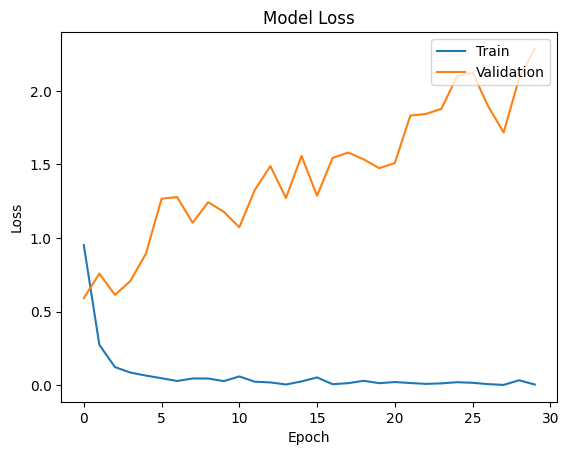

In [40]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Tampak jelas bahwa performa model di atas sangat rendah. Model hanya benar 50 persen saja ibarat melempar koin.

- **Precision** : Prediksi model pada kelas 0 (notsmoking) hanya benar 50 persen, sedangkan kelas 1 (smoking) tidak pernah benar.

- **Recall** : Kebalikan dari precision, model dapat mendeteksi 100 persen dari kelas 0 (notsmoking) secara nyata, sedangkan model tidak dapat mendeteksi 1 pun dari kelas 1 (smoking).

- **F1 Score**: Harmonisasi recall dan precision pada model cukup bagus di kelas 0, tetapi buruk di kelas 1.

Performa buruk model ini juga terlihat dari confusion matrix. Model mendeteksi seluruhnya sebagai negatif, entah itu benar atau tidak pada kenyataannya. <br><br>
Selain itu, menurut plot **Model Lost**, terlihat ini mengalami overfitting yang parah.

Meskipun performanya sangat baik pada data training, kemampuannya untuk generalisasi pada data testing sangat buruk. Model perlu dioptimasi lebih lanjut untuk meningkatkan kemampuan generalisasinya.<br><br>

**Jadi, secara umum, model butuh peningkatan (improvement).**

# 7. ANN Improvement

Berkaca dari hasil training model sebelumnya, saya memutuskan untuk melakukan peningkatan dengan melakukan transfer learning. Harapannya, performa model tersebut bisa meningkat signifikan.

## 7.1. Model Definition

Pada sub bagian ini, saya akan melakukan model definition yang mencakup sejumlah langkah sekaligus, dimula dari menerapkan seed hingga melakukan transfer learning dengan menggunakan MobileNetV3Large sebagai basisnya.

In [43]:
# Tentukan seed untuk hasil yang konsisten
seed = 42
tf.random.set_seed(seed)

# Ukuran gambar dan jumlah kelas
img_size = 250  # Sesuaikan ukuran gambar
n_classes = 2  # Misalnya, 2 kelas (smoking dan not_smoking)

# Load MobileNetV3Large sebagai base model
base_model = MobileNetV3Large(
    input_shape=(img_size, img_size, 3),  # Input shape sesuai ukuran gambar
    include_top=False,  # Hilangkan fully connected layer terakhir
    weights='imagenet'  # Gunakan bobot pretrained dari ImageNet
)

# Atur layer yang tidak dilatih
base_model.trainable = True
fine_tune_layers = 100
for layer in base_model.layers[:fine_tune_layers]:
    layer.trainable = False  # Freeze layer awal

# Buat model Sequential dengan MobileNetV3Large sebagai base
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Pooling untuk meratakan output
    layers.Dropout(0.5),  # Dropout untuk regularisasi
    layers.Dense(n_classes, activation='softmax')
])

# Compile model dengan optimizer dan loss function
model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),  # Learning rate kecil untuk fine-tuning
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callback untuk early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Tentukan jumlah epoch dan batch size
fine_tune_epochs = 25
total_epochs = epochs + fine_tune_epochs  # `epochs` adalah jumlah epoch dari training sebelumnya
batch_size = 8


/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


## 7.2. Model Training

Di sini, saya akan melatih model yang telah dituning.

In [44]:
# Melatih model menggunakan data augmented
history_tuned = model.fit(
    augmented_images, augmented_labels,  # Data augmented
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Mulai dari epoch terakhir sebelum fine-tuning
    batch_size=batch_size,
    validation_data=(x_test, y_test_encoded),  # Data validasi
    callbacks=[early_stopping]  # Gunakan early stopping untuk menghentikan pelatihan jika overfitting
)

Epoch 30/55
448/448 ━━━━━━━━━━━━━━━━━━━━ 71s 67ms/step - accuracy: 0.5382 - loss: 0.8574 - val_accuracy: 0.6652 - val_loss: 0.6527
Epoch 31/55
448/448 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.6877 - loss: 0.6001 - val_accuracy: 0.7634 - val_loss: 0.4844
Epoch 32/55
448/448 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.7652 - loss: 0.4862 - val_accuracy: 0.8170 - val_loss: 0.4011
Epoch 33/55
448/448 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8117 - loss: 0.4145 - val_accuracy: 0.8438 - val_loss: 0.3600
Epoch 34/55
448/448 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8294 - loss: 0.3724 - val_accuracy: 0.8527 - val_loss: 0.3284
Epoch 35/55
448/448 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.8692 - loss: 0.3130 - val_accuracy: 0.8571 - val_loss: 0.3078
Epoch 36/55
448/448 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8967 - loss: 0.2581 - val_accuracy: 0.8571 - val_loss: 0.2892
Epoch 37/55
448/448 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9150 - loss: 0.223

## 7.3. Model Evaluation

Setelah itu, mari mengecek evaluasi, apakah ada peningkatan atau tidak setelah improvement atau tuning tadi.

In [45]:
# Evaluasi setelah fine-tuning setelah melakukan early stopping
y_pred_fine = model.predict(x_test)
y_pred_fine_classes = np.argmax(y_pred_fine, axis=1)

print("Evaluasi setelah fine-tuning:")
print(classification_report(y_test, y_pred_fine_classes))
print(f"Accuracy: {accuracy_score(y_test, y_pred_fine_classes)}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_fine_classes))


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step
Evaluasi setelah fine-tuning:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       112
           1       0.88      0.88      0.88       112

    accuracy                           0.88       224
   macro avg       0.88      0.88      0.88       224
weighted avg       0.88      0.88      0.88       224

Accuracy: 0.8839285714285714
Confusion Matrix:
[[99 13]
 [13 99]]


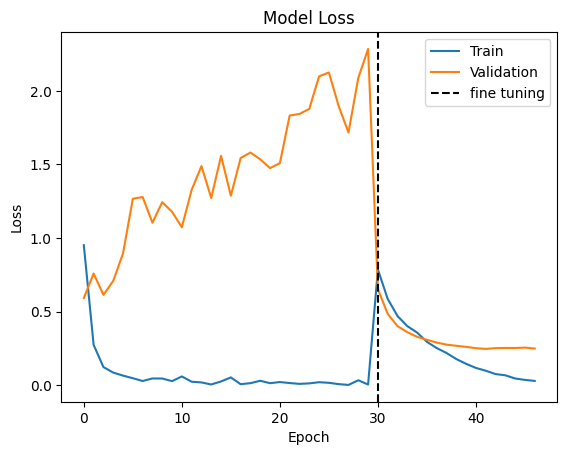

In [46]:
combined_loss = history.history['loss'] +  history_tuned.history['loss']
combined_val_loss = history.history['val_loss'] +  history_tuned.history['val_loss']

# Plot the combined loss values
plt.plot(combined_loss)
plt.plot(combined_val_loss)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


# Add a vertical line to visually separate the two training sessions
plt.axvline(x=len(history.history['loss']), color='k', linestyle='--')
plt.legend(['Train', 'Validation','fine tuning'], loc='upper right')
plt.show()

# 8. Model Saving

Setelah terbukti memang peningkatan dalam performa model, saya akan menyimpan model yang telah dituning dan melanjutkannya ke tahapan model inference dan deployment.

In [47]:
drive.mount('/content/drive')

# Menyimpan model ke Google Drive
model.save('/content/drive/MyDrive/smoker_detection_model.h5')
print("Model berhasil diunggah ke Google Drive!")

Mounted at /content/drive
Model berhasil diunggah ke Google Drive!


# 9. Model Inference

In [48]:
predictions = model.predict(x_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [49]:
predictions[0]

array([0.9422193 , 0.05778071], dtype=float32)

In [50]:
class_name = {1: 'smoking', 0: 'notsmoking'}
def plot_image(i,pred_array,true_label,img):
  pred_array , true_label , img= pred_array[i] , true_label[i] , img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img,cmap=plt.cm.binary)
  predicted_label = np.argmax(pred_array)


  if(predicted_label == true_label):
      color='blue'
  else:
     color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_name[predicted_label],
                                        100*np.max(pred_array),
                                        class_name[true_label])).set_color(color)
  plt.title("Image {}".format(i + 1))


def plot_activation_value(i,pred_array,true_label):
  pred_array , true_label = pred_array[i] , true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(2),pred_array,color="#777777")
  plt.ylim([0,1])
  predicted_label = np.argmax(pred_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
  top_classes = np.argsort(pred_array)[-3:][::-1]

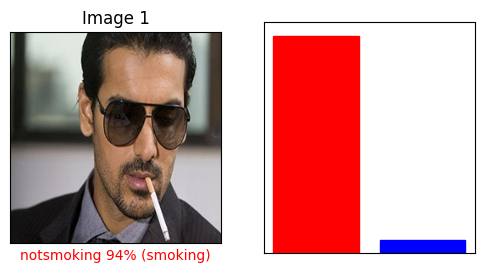

In [51]:
i=0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i , predictions , y_test_encoded , x_test)
plt.subplot(1,2,2)
plot_activation_value(i,predictions,y_test_encoded)
plt.show()

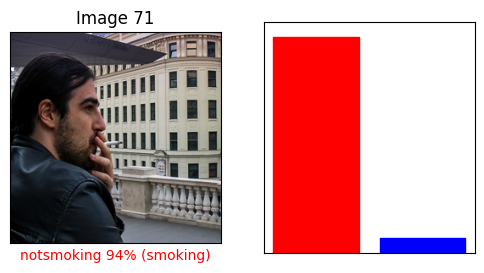

In [52]:
i=70
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i , predictions , y_test_encoded , x_test)
plt.subplot(1,2,2)
plot_activation_value(i,predictions,y_test_encoded)
plt.show()

# 10. Pengambilan Kesimpulan